# Curing Kinetics

## 📖 Introduction

The curing of epoxy resins with polyfunctional amines is an excellent example of a step-growth polymerization resulting in a cross-linked thermoset structure. In this notebook, we will consider the reaction of a bifunctional epoxy prepolymer with a diamine. The diamine is a tetrafunctional species, since each amino hydrogen is capable of reacting with an epoxy group: 

<img src="./epoxy-amine-reaction.png" width="800" alt="epoxy-amine-reaction">

The reaction progress of a diamine molecule can be represented as a series of successive states, as shown in the following scheme:

<img src="./diamine-reaction.png" width="600" alt="diamine-reaction">

where $A_i$ denotes an amine molecule with $i$ reacted amino hydrogens. 

Instead of explicitly tracking each of the six possible diamine configurations, one could formulate a kinetically equivalent reaction scheme in terms of the primary and secondary amine groups only. However, the slightly more sophisticated approach chosen here has some advantages (e.g., $M_{\mathrm{w}}$ calculation), as will be seen later.

For a closed system with constant volume, the transient balances for the various species involved in the reaction network are given by:

\begin{align}
\frac{\mathrm{d}[A_0]}{\mathrm{d}t}    &= -r_{01}                \\
\frac{\mathrm{d}[A_1]}{\mathrm{d}t}    &= +r_{01}-r_{12}-r_{12'} \\
\frac{\mathrm{d}[A_2]}{\mathrm{d}t}    &= +r_{12}-r_{23}         \\
\frac{\mathrm{d}[A_{2'}]}{\mathrm{d}t} &= +r_{12'}-r_{2'3}       \\
\frac{\mathrm{d}[A_3]}{\mathrm{d}t}    &= +r_{23}+r_{2'3}-r_{34} \\
\frac{\mathrm{d}[A_4]}{\mathrm{d}t}    &= +r_{34}                \\
\frac{\mathrm{d}[E]}{\mathrm{d}t}      &= -\sum_i r_i            \\
\frac{\mathrm{d}[OH]}{\mathrm{d}t}     &= +\sum_i r_i
\end{align}

The corresponding rate expressions are:

\begin{align}
r_{01}  &= 4 k_1 [E] [A_0]     \\
r_{12}  &= 2 k_1 [E] [A_1]     \\
r_{12'} &= 1 k_2 [E] [A_1]     \\
r_{23}  &= 2 k_2 [E] [A_2]     \\
r_{2'3} &= 2 k_1 [E] [A_{2'}]  \\
r_{34}  &= 1 k_2 [E] [A_3]
\end{align}

where $k_1$ and $k_2$ are _apparent_ second-order rate coefficients that account for both the *u*ncatalyzed and OH-*c*atalyzed reaction pathways between an epoxy group and a primary or secondary amine, respectively. They are typically expressed as:

\begin{align}
k_1 & = k_{1,{\mathrm{u}}} + k_{1,{\mathrm{c}}} [OH] \\
k_2 & = \beta k_1
\end{align}

with $\beta \le 1$ representing the relative reactivity of a secondary amino hydrogen compared to a primary amino hydrogen. This reduced reactivity is due to steric hindrance and electronic effects, which make secondary amines less nucleophilic than primary amines.

Interestingly, the total epoxy consumption rate can be rewritten in a simple and insightful form:

\begin{equation}
\sum_i r_i = k_1 \left( 4[A_0]+2[A_1]+2[A_{2'}] \right)[E] + k_2 \left( 1[A_1]+2[A_2]+1[A_3] \right)[E]
\end{equation}

where the expressions in parentheses represent the total concentration of primary and secondary amino hydrogens, respectively.

The conversion of epoxy groups follows the standard definition:

\begin{equation}
\chi_{\mathrm{e}} = 1 - \frac{[E]}{[E]_0} 
\end{equation}

and the overall conversion of amine groups is given by:

\begin{equation}
\chi_{\mathrm{a}} = 1 - \frac{4[A_0]+3[A_1]+2[A_2]+2[A_{2'}]+1[A_3]}{4[A_0]_0} 
\end{equation}

The evolution of the average molecular weight (until the gel point) can be calculated based on the concentration profiles of the various reacting species. In the special case of $\beta=1$, we can employ the simple and well-known [Stockmayer (1952)] solution for step-growth polymerization. In general, however, the unequal reactivity of amine hydrogens complicates the analytical treatment, requiring a more powerful technique, such as the expectation theory of [Miller & Macosko (1980)]. The full analytical expressions are provided in the documentation for [polykin.stepgrowth.solutions.Miller_2], which we will use here. An important input to this function is the fraction of diamine units with exactly $i$ reacted sites, which, in our case, is expressed as:

\begin{equation}
p_i = \frac{[A_i]}{[A_0]_0} \;, i \ge 1
\end{equation}

This last calculation step is the main reason for adopting a reaction scheme that explicitly accounts for the different diamine configurations.

Enough theory! Let's implement this epoxy curing model and estimate the corresponding rate coefficients from experimental data.

[Stockmayer (1952)]: https://doi.org/10.1002/pol.1952.120090106
[Miller & Macosko (1980)]: https://doi.org/10.1021/ma60077a008
[polykin.stepgrowth.solutions.Miller_2]: https://hugomvale.github.io/polykin/reference/stepgrowth/solutions/#polykin.stepgrowth.solutions.Miller_2

## 🧮 Model Implementation

If running this notebook in Google Colab, please uncomment the extra lines below.

In [1]:
# %pip install polykin

In [2]:
from copy import deepcopy
from enum import IntEnum

import matplotlib.pyplot as plt
import numpy as np
from polykin.stepgrowth.solutions import Miller_2
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

For better readability, we define symbolic indices for the different species and reactions implemented in the simulation. These indices will make the code more intuitive and reduce the likelihood of errors when referencing specific components.

In [3]:
class Ix(IntEnum):
    A0  = 0  # Amine A_0
    A1  = 1  # Amine A_1
    A2  = 2  # Amine A_2
    A2p = 3  # Amine A_2'
    A3  = 4  # Amine A_3
    A4  = 5  # Amine A_4
    E   = 6  # Epoxy
    OH  = 7  # Hydroxyl

class Irxn(IntEnum):
    r01  = 0  # A_0 -> A_1
    r12  = 1  # A_1 -> A_2
    r12p = 2  # A_1 -> A_2'
    r23  = 3  # A_2 -> A_3
    r2p3 = 4  # A_2'-> A_3
    r34  = 5  # A_3 -> A_4

We will begin by implementing a helper function `arrhenius` to describe the temperature dependence of the rate coefficients.

In [4]:
def arrhenius(T: float, k0: float, Ea: float, T0: float) -> float:
    """Arrhenius equation.

    Parameters
    ----------
    T : float
        Temperature (°C).
    k0 : float
        Value of rate coefficient at `T0` (#/s).
    Ea : float
        Energy of activation (J/mol).
    T0 : float
        Reference temperature (°C).

    Returns
    -------
    float
        Value of rate coefficient at `T`.
    """
    R = 8.314  # J/(mol·K)
    return k0 * np.exp(-Ea / R * (1/(273.15 + T) - 1/(273.15 + T0)))

Now, we implement a function to compute the derivative of the state vector, which contains the concentrations all species.

In [ ]:
def model_xdot(t: float, x: np.ndarray, T: float, params: dict) -> np.ndarray:
    """Calculate derivative of the state vector, dx/dt.

    Parameters
    ----------
    t : float
        Time (s).
    x : np.ndarray
        State vector.
    T : float
        Temperature (°C).
    params : dict
        Model parameters.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """

    # Unpack the state vector
    A0  = x[Ix.A0]
    A1  = x[Ix.A1]
    A2  = x[Ix.A2]
    A2p = x[Ix.A2p]
    A3  = x[Ix.A3]
    # A4 = x[Ix.A4]
    E   = x[Ix.E]
    OH  = x[Ix.OH]

    # Rate coefficients
    k1u = arrhenius(T, **params['k1u'])
    k1c = arrhenius(T, **params['k1c'])
    beta = params['beta']
    k1 = k1u + k1c*OH
    k2 = beta*k1

    # Reaction rates
    r = np.empty(len(Irxn))
    r[Irxn.r01]  = 4*k1*E*A0
    r[Irxn.r12]  = 2*k1*E*A1
    r[Irxn.r12p] =   k2*E*A1
    r[Irxn.r23]  = 2*k2*E*A2
    r[Irxn.r2p3] = 2*k1*E*A2p
    r[Irxn.r34]  = 1*k2*E*A3

    # Derivatives
    xdot = np.empty_like(x)
    xdot[Ix.A0]  = -r[Irxn.r01]
    xdot[Ix.A1]  = +r[Irxn.r01] - r[Irxn.r12] - r[Irxn.r12p]
    xdot[Ix.A2]  = +r[Irxn.r12] - r[Irxn.r23]
    xdot[Ix.A2p] = +r[Irxn.r12p] - r[Irxn.r2p3]
    xdot[Ix.A3]  = +r[Irxn.r23] + r[Irxn.r2p3] - r[Irxn.r34]
    xdot[Ix.A4]  = +r[Irxn.r34]
    xdot[Ix.E]   = -r.sum()
    xdot[Ix.OH]  = -xdot[Ix.E]

    return xdot

Then, we perform the numerical integration using a suitable ODE solver. Since this system is non-stiff, we could use an explicit scheme like `RK45`. However, `LSODA` is still faster, so we use it instead.

In comparison to the previous notebooks, we have added the `teval` argument. This optional argument specifies the times at which the solution should be evaluated. As we will see below, it is particularly useful when fitting the model to experimental data.

In [ ]:
def solve_model(
    E_0: float,
    A0_0: float,
    T: float,
    params: dict,
    tend: float,
    teval: np.ndarray | None = None
) -> dict[str, np.ndarray]:
    """Solve the dynamic model.

    Parameters
    ----------
    E_0 : float
        Initial concentration of epoxyde groups (mol/L).
    A0_0 : float
        Initial concentration of unreacted amine molecules (mol/L)
    T : float
        Temperature (°C).
    params : dict
        Model parameters.
    tend : float
        End simulation time (s).
    teval : np.ndarray | None
        Times at which the solution is to be evaluated.

    Returns
    -------
    dict[str, np.ndarray]
        times (`t`), concentrations (`x`), conversion epoxy groups (`Xe`),
        conversion amine groups (`Xa`).
    """

    # Initial conditions
    x0 = np.zeros(len(Ix))
    x0[Ix.E]  = E_0
    x0[Ix.A0] = A0_0

    solution = solve_ivp(model_xdot,
                         t_span=(0.0, tend),
                         t_eval=teval,
                         y0=x0,
                         args=(T, params),
                         method='LSODA',
                         rtol=1e-6,
                         atol=1e-10)

    # Unpack the solution
    t = solution.t
    x = solution.y

    # Check mass balance
    assert np.allclose(
        x[Ix.A0] + x[Ix.A1] + x[Ix.A2] + x[Ix.A2p] + x[Ix.A3] + x[Ix.A4], A0_0,
        rtol=1e-4), \
        "Oops, mass-balance violated!"

    # Conversions
    Xe = 1 - x[Ix.E]/E_0
    Xa = 1 - (4*x[Ix.A0] + 3*x[Ix.A1] + 2*x[Ix.A2] + 2*x[Ix.A2p] + x[Ix.A3])/(4*A0_0)

    # Fraction of diamine units with `i` reacted sites
    p = np.empty((4, t.size))
    p[0] = x[Ix.A1]
    p[1] = x[Ix.A2] + x[Ix.A2p]
    p[2] = x[Ix.A3]
    p[3] = x[Ix.A4]
    p /= A0_0

    return {'t': t, 'x': x, 'Xe': Xe, 'Xa': Xa, 'p': p}

## 📊 Results and Visualization

The key parameters consist of $\beta$, $k_{1,\mathrm{u}}$ and $k_{1,\mathrm{c}}$. The ratio $\beta$ is set to the value reported by [Girard-Reydet et al. (1995)], while the two kinetic rate coefficients are simply assigned plausible initial guesses. These coefficients will be estimated from experimental data later in the analysis.

[Girard-Reydet et al. (1995)]: https://doi.org/10.1021/ma00127a003

In [7]:
params = {
    'beta': 0.65,
    'k1u': {
        'k0': 1e-6, # L/(mol·s)
        'Ea': 50e3, # J/mol
        'T0': 130.  # °C
    },
    'k1c': {
        'k0': 2e-5, # L²/(mol²·s)
        'Ea': 50e3, # J/mol
        'T0': 130.  # °C
    },
    'MM': {
        'DGEBA': 340., # g/mol
        'MCDEA': 379.  # g/mol
    }
}

Let's simulate the curing of a hypothetical stoichiometric epoxy-amine mixture at 130°C and see if the results make sense.

In [ ]:
def plot_model_solution(
    E_0: float,
    A0_0: float,
    T: float,
    params: dict,
    tend: float
) -> None:
    """Plot the model solution.

    Parameters
    ----------
    E_0 : float
        Initial concentration of epoxyde groups (mol/L).
    A0_0 : float
        Initial concentration of unreacted amine molecules (mol/L)
    T : float
        Temperature (°C).
    params : dict
        Model parameters.
    tend : float
        End simulation time (s).
    """

    # Solve the model
    solution = solve_model(E_0, A0_0, T, params, tend)

    # Plots
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 7))
    fig.suptitle("Epoxy-Amine Curing")
    fig.tight_layout()

    t_hour = solution['t']/3600

    # Concentration of amine species
    for idx, name in zip([Ix.A0, Ix.A1, Ix.A2, Ix.A2p, Ix.A3, Ix.A4],
                         ["$A_0$", "$A_1$", "$A_2$", r"$A_{2'}$", "$A_3$", "$A_4$"]):
        ax[0].plot(t_hour, solution['x'][idx], label=name)

    ax[0].set_ylabel("Concentration (mol/L)")
    ax[0].grid(True)
    ax[0].legend(loc='upper right')

    # Endgroup conversions
    ax[1].plot(t_hour, 1e2*solution['Xe'], label="epoxy")
    ax[1].plot(t_hour, 1e2*solution['Xa'], label="amine", linestyle='--')
    ax[1].set_ylabel("Conversion (%)")
    ax[1].grid(True)
    ax[1].legend(loc='best')

    # Mn and Mw
    Mn = np.full(solution['t'].size, np.nan)
    Mw = Mn.copy()
    igel = -1
    for i in range(1, solution['t'].size):
        Mn[i], Mw[i] = Miller_2(nAf=solution['x'][Ix.A0, 0],
                                nB2=solution['x'][Ix.E,  0]/2, f=4,
                                MAf=params['MM']['MCDEA'],
                                MB2=params['MM']['DGEBA'],
                                p=solution['p'][:, i])
        if np.isnan(Mn[i]):
            igel = i
            break
    
    ax[2].plot(t_hour, Mn, label=r"$M_{\mathrm{n}}$")
    ax[2].plot(t_hour, Mw, label=r"$M_{\mathrm{w}}$")
    ax[2].set_ylabel("Molar mass (g/mol)")
    ax[2].set_yscale('log')
    ax[2].grid(True)
    ax[2].legend(loc='best')

    # Gel point (slightly overestimated)
    xgel = 1e2*solution['Xe'][igel]
    ax[2].text(t_hour[igel+2], np.sqrt(Mw[1]*Mw[igel-1]),
               r"$\chi_{\mathrm{gel}} \approx$" + f"{xgel:.1f}%",
               bbox=dict(facecolor="white", edgecolor="none"))
    ax[2].axvline(t_hour[igel], linestyle='--')

    ax[-1].set_xlabel("Time (h)")

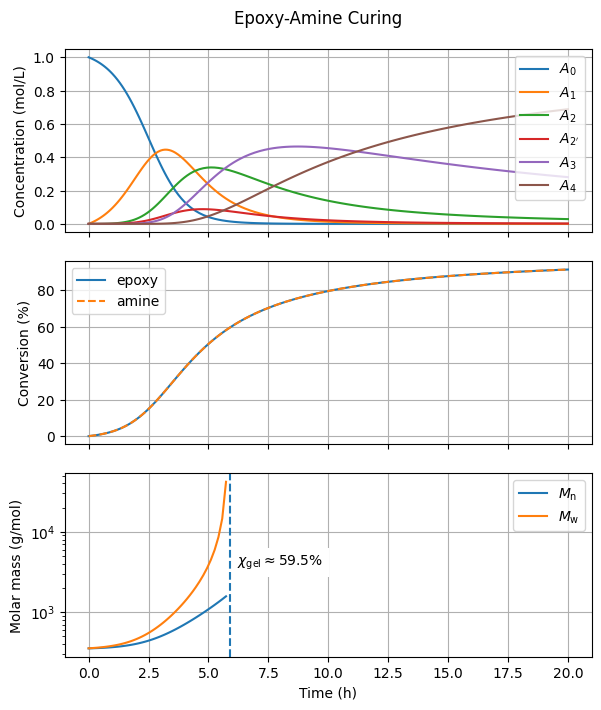

In [9]:
plot_model_solution(E_0=4.0, A0_0=1.0, T=130.0, params=params, tend=3600*20)

The concentration profiles of amine species ($A_0, A_1, A_2$, etc.) exhibit the characteristic rise and fall expected in a consecutive reaction scheme. Each intermediate forms, reaches a peak, and then declines as it reacts further.  

The end-group conversion profiles display a sigmoidal shape, which is typical of autocatalytic processes. Initially, the curing reaction proceeds solely via the uncatalyzed pathway. As more OH groups are formed, the OH-catalyzed pathway becomes dominant, leading to an overall increase in the reaction rate.

The conversions of epoxy and amine end groups are identical because this simulation represents an equimolar mixture. Feel free to modify the arguments `E_0` and `A0_0` to explore different initial conditions.

The gel point is reached at slightly below 60% conversion. As expected, this value is somewhat higher than the prediction from the Stockmayer equation, $\chi_{\mathrm{gel}} = \frac{1}{\sqrt{(2-1)(4-1)}} = \frac{1}{\sqrt{3}} \approx 0.58$. The discrepancy between these values increases as $\beta$ decreases.

## 🔢 Model Fit

In this section, we compare the model predictions with experimental data and adjust the kinetic parameters to improve agreement.


### Experimental Data

We load experimental data for the [DGEBA]-[MCDEA] system at three different temperatures from [Girard-Reydet et al. (1995)]. The data were digitized from Figure 3b and are used to validate the model and estimate key kinetic parameters.

[DGEBA]: https://en.wikipedia.org/wiki/Bisphenol_A_diglycidyl_ether
[MCDEA]: https://pubchem.ncbi.nlm.nih.gov/compound/4_4_-Methylenebis_3-chloro-2_6-diethylaniline

In [ ]:
data = [
    {'E_0': 4.5,     # mol/L
     'A0_0': 4.5/4,  # mol/L
     'T': 160,       # °C
     'lnt': [2.289, 3.391, 3.678, 3.908, 4.100, 4.243, 4.382, 4.502, 4.607, 4.693, 4.780, 4.866, 4.933, 5.057], # min
     'Xe': [0.016, 0.073, 0.106, 0.154, 0.214, 0.273, 0.362, 0.406, 0.472, 0.538, 0.610, 0.660, 0.688, 0.729]   # -
    },
    {'E_0': 4.5,
     'A0_0': 4.5/4,
     'T': 135,
     'lnt': [3.678, 4.387, 4.799, 5.067, 5.287, 5.460, 5.603, 5.738, 5.862],
     'Xe': [0.020, 0.056, 0.124, 0.209, 0.351, 0.440, 0.571, 0.655, 0.727]
    },
    {'E_0': 4.5,
     'A0_0': 4.5/4,
     'T': 80,
     'lnt': [6.197, 6.877, 7.280, 7.557, 7.778, 7.950, 8.036, 8.103, 8.170, 8.252, 8.305, 8.372, 8.587],
     'Xe': [0.003, 0.055, 0.062, 0.124, 0.164, 0.253, 0.325, 0.387, 0.455, 0.534, 0.606, 0.656, 0.732]
    }
]

The x-axis in the published figure is $\ln t$ (min), so we convert it to time in seconds.

In [11]:
for d in data:
    d['t'] = np.exp(d['lnt'])*60 # s
    d['Xe'] = np.array(d['Xe'])

Let's overlay the experimental data with the model predictions obtained using the initial parameter set.

In [12]:
def plot_model_vs_data(data: list[dict], params: dict) -> None:
    """Plot model vs data.

    Parameters
    ----------
    data : list[dict]
        Experimental data sets.
    params : dict
        Model parameters.
    """

    fig, ax = plt.subplots()
    fig.suptitle("Model vs Data")
    fig.tight_layout()

    for d in data:
        ax.scatter(d['t']/3600, 1e2*d['Xe'], label=f"{d['T']}°C")
        solution = solve_model(E_0=d['E_0'],
                               A0_0=d['A0_0'],
                               T=d['T'],
                               params=params,
                               tend=d['t'][-1])
        ax.plot(solution['t']/3600, 1e2*solution['Xe'])

    ax.set_xlabel("Time (h)")
    ax.set_xlim(1e-1, 1e2)
    ax.set_ylabel("Conversion epoxy (%)")
    ax.set_ylim(0.0, 80.0)
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend(loc='best')

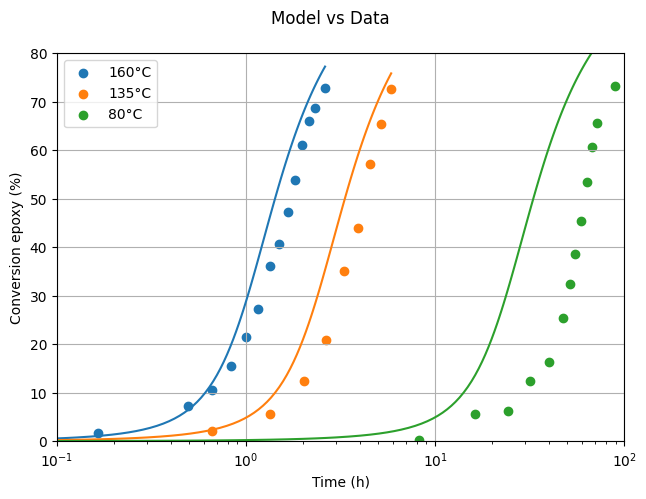

In [13]:
plot_model_vs_data(data, params)

Not too bad for starters! There's clearly room for quantitative improvement, but qualitatively, the model already reproduces the experimental trends.

### Parameter Estimation

To estimate the kinetic parameters, we first implement a function to evaluate the sum of squared errors (SSE) between the model predictions and the experimental results. The signature of this function is determined by the optimization routine, in our case, `scipy.optimize.minimize`.

In [14]:
def sse(p: np.ndarray) -> float:
    """Evaluate the sum of squared errors (SSE).

    Parameters
    ----------
    p : np.ndarray
        Parameters to be optimized.

    Returns
    -------
    float
        The sum of squared errors (SSE).
    """

    # Create a copy of the parameters to avoid modifying the original
    _params = deepcopy(params)
    _params['k1u']['k0'] = p[0]
    _params['k1c']['k0'] = p[1]
    _params['k1c']['Ea'] = p[2]
    _params['k1u']['Ea'] = p[2]

    result = 0.0
    for d in data:
        solution = solve_model(E_0=d['E_0'],
                               A0_0=d['A0_0'],
                               T=d['T'],
                               params=_params,
                               tend=d['t'][-1],
                               teval=d['t'])
        delta = d['Xe'] - solution['Xe']
        result += np.dot(delta, delta)

    return result

The optimization process is performed using the `minimize` function with the Nelder-Mead method to estimate the parameters that minimize the sum of squared errors. The order of the parameters passed to `minimize` must match the order implemented in the `sse` function.

In [15]:
optsol = minimize(fun=sse,
                  x0=[params['k1u']['k0'],
                      params['k1c']['k0'],
                      params['k1u']['Ea']],
                  method='Nelder-Mead')
optsol

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.04023248813072973
             x: [ 4.374e-07  1.674e-05  5.803e+04]
           nit: 123
          nfev: 234
 final_simplex: (array([[ 4.374e-07,  1.674e-05,  5.803e+04],
                       [ 4.374e-07,  1.674e-05,  5.803e+04],
                       [ 4.374e-07,  1.674e-05,  5.803e+04],
                       [ 4.374e-07,  1.674e-05,  5.803e+04]]), array([ 4.023e-02,  4.023e-02,  4.023e-02,  4.023e-02]))

In this case, it worked right away, but don't take this as a rule! More often than not, you'll need to adjust the initial guess, try different solver methods, rescale/transform the parameters (e.g., $\log$), and potentially include parameter bounds.

Let's verify the results by overlaying the experimental data with the model predictions using the estimated parameters.

In [16]:
params_opt = deepcopy(params)
params_opt['k1u']['k0'] = optsol.x[0]
params_opt['k1c']['k0'] = optsol.x[1]
params_opt['k1u']['Ea'] = optsol.x[2]
params_opt['k1c']['Ea'] = optsol.x[2]

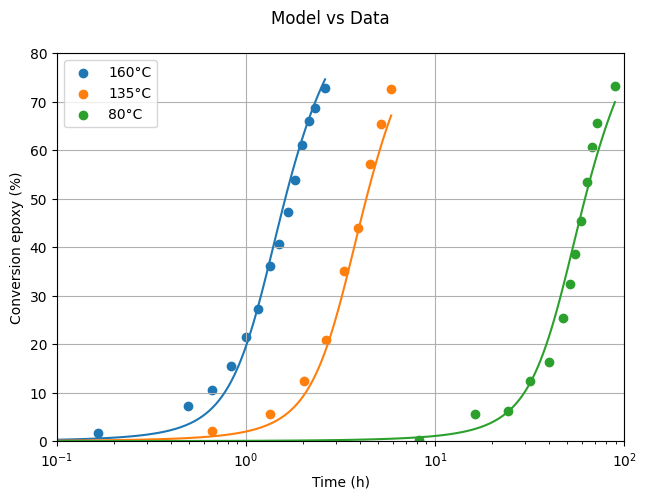

In [17]:
plot_model_vs_data(data, params_opt)

Looking at the plot, it's clear that the model fits the experimental data quite well, showing that the estimated parameters are on point.

## 🔎 Questions

1. How would you describe the contribution of the OH-catalyzed pathway relative to the uncatalyzed pathway? What happens if $k_{1,\mathrm{u}}$ is set to 0?
2. Formulate a simpler, yet equivalent kinetic model in terms of the amine groups (primary and secondary).